1. 사이즈 정보 미리 저장. TLE 미리저장
2. Pcmax 구하기
3. 각각의 사이즈정보
4. 비율=오차
5. celestrak의 HBR 역추적


## Import 및 매트랩 연동

In [1]:
from sgp4.api import Satrec
from sgp4.api import jday
from astropy.time import Time
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord, TEME
from datetime import timedelta, datetime
import pandas as pd
import requests
import json
import configparser
from tqdm import tqdm
from math import sqrt
import json
import requests
import configparser
import time

import matlab.engine
from math import exp
eng=matlab.engine.start_matlab()
eng.addpath('C:/Users/VDRC/Documents/MATLAB/single_covariance_maximum_Pc/Main/ProbabilityOfCollisionCode',nargout=0)
Tol     = 1e-09
HBRType = 'squareEquArea'

## 함수 선언

In [2]:
# TCA로 부터 DSE만큼의 과거 데이터를 most recent TLE로 잡는다.
# 14 days histroical covariance 계산
def covariance(object, TCA, DSE , jd, fr ):

    mostrecent_epoch = (TCA-DSE)  # TCA와 기준 에포크와의 차이 이용해 현 에포크 시점 계산.
    mostrecent_epoch = mostrecent_epoch + timedelta(hours=1) # 1시간정도 여유시간둬서 정함.

    delta = timedelta(days=14)
    startdate = str(mostrecent_epoch-delta)
    enddate = str(mostrecent_epoch)
    requestFindObjects = r= f"/class/tle/EPOCH/>{startdate}%2C<{enddate}/NORAD_CAT_ID/{object}/orderby/EPOCH%20asc" # 현재시점으로부터 과거 14일 데이터 불러오기

    EPOCH, TLE_LINE1, TLE_LINE2 = get_tle_element( requestFindObjects)

    TLE=np.concatenate((EPOCH,TLE_LINE1, TLE_LINE2), axis=1)
    satellite = Satrec.twoline2rv(TLE[-1][1], TLE[-1][2]) 
    e1, r1, v1 = satellite.sgp4(jd,fr) #TCA 시점 state vector

    epoch = [arr[0] for arr in TLE]
    line1 = [arr[1] for arr in TLE]
    line2 = [arr[2] for arr in TLE]

    epoch_date = np.vectorize(str_to_datetime)(epoch) #datetime으로 변환.

    mostrecent_epoch = epoch_date[-1] # 가장 최근시점을 예측한다.
    N = epoch_date.size #총 TLE 개수 24개 

    delta_r = []
    delta_v = []

    true_position, true_velocity = get_state_ECI(mostrecent_epoch, line1, line2, N-1)

    for i in range(N-1): # 기준 시점은 제외.
        r_ECI, v_ECI = get_state_ECI(mostrecent_epoch, line1, line2,i)
        r_residual = tuple(r_ECI-true_position)
        v_residual = tuple(v_ECI-true_velocity)

        delta_r.append((r_residual)) #잔차 r
        delta_v.append((v_residual)) #잔차 v
    
    bar_X_epoch = np.hstack((np.array(delta_r), np.array(delta_v))) # 23 X 6
    # 평균 계산 후 공분산 계산
    m = np.mean(bar_X_epoch,axis=0) # 1 X 6
    a=bar_X_epoch-m

    cov1 = (np.transpose(a)@a)/len(a)
    cov1 = cov1[:3][:,:3]

   
    return r1, v1, cov1

# spack-track TLE 주소를 넣고 TLE 모든요소 불러오기. 공분산 계산 시 활용
def get_tle_element(requestFindObjects):

    r_f_d = requestFindObjects # 2주치동안 특정위성을 뽑는 쿼리.
    # set of satellite ids of objects included in TLE data
    Epoch_LIST = []
    TLE1_LIST = []
    TLE2_LIST = []
    # Use configparser package to pull in the ini file (pip install configparser)
    config = configparser.ConfigParser()
    config.read("./Login.ini")
    configUsr = config.get("configuration", "username")
    configPwd = config.get("configuration", "password")
    siteCred = {'identity': configUsr, 'password': configPwd}

    with requests.Session() as session:
        # run the session in a with block to force session to close if we exit
        uriBase = "https://www.space-track.org"
        requestLogin = "/ajaxauth/login"
        requestCmdAction = "/basicspacedata/query"
        # need to log in first. note that we get a 200 to say the web site got the data, not that we are logged in
        response = session.post(uriBase + requestLogin, data=siteCred)
        if response.status_code != 200:
            print("Error, POST fail on login")

        # this query picks up objects from the catalog. Note - a 401 failure shows you have bad credentials
        response = session.get(uriBase + requestCmdAction + r_f_d)
        if response.status_code != 200:
            print("Error, GET fail on request")

        data = json.loads(response.text)
        for object in data:
            Epoch = object['EPOCH']
            print(Epoch)
            Epoch_LIST.append(Epoch)
            TLE1 = object['TLE_LINE1']
            TLE1_LIST.append(TLE1)
            TLE2 = object['TLE_LINE2']
            TLE2_LIST.append(TLE2)
        session.close()
        Epoch_LIST=np.array(Epoch_LIST).reshape(-1,1)
        TLE1_LIST=np.array(TLE1_LIST).reshape(-1,1)
        TLE2_LIST=np.array(TLE2_LIST).reshape(-1,1)
    return Epoch_LIST , TLE1_LIST, TLE2_LIST

def get_discos_tle_objects(SATNO_CHUNK_STR):
    response = requests.get(
        f'{DISCOS_URL}/api/objects',
        headers={
            'Authorization': f'Bearer {DISCOS_TOKEN}',
            'DiscosWeb-Api-Version': '2',
        },
        params={
            'filter': f'in(satno,{SATNO_CHUNK_STR})',
            'page[size]': f'{DISCOS_PAGE_SIZE_MAX}',
            'sort': 'satno',            
        }
    )
    doc = response.json()
    DISCOS_OBJECTS = doc['data']
    return DISCOS_OBJECTS

# TLE데이터를 통해 datetime시점에서의 statevector 계산
def get_state_ECI(epoch_target, TLE_Line1, TLE_Line2,i):
    target_day=epoch_target
    firstLine=TLE_Line1
    secondLine=TLE_Line2

    yr, mon, day = target_day.year, target_day.month, target_day.day
    hour, min, sec = target_day.hour, target_day.minute, target_day.second
    jd, fr = jday(yr, mon, day, hour, min, sec)

    satellite = Satrec.twoline2rv(firstLine[i],secondLine[i]) 
    e, r, v = satellite.sgp4(jd,fr)
    r_np=np.array(r)
    v_np=np.array(v)
    return r_np, v_np

#string을 datetime으로 변환
def str_to_datetime(date_str):

    return datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')

# 위성의 몸체를 둘러싸는 직육면체를 가정. 직육면체의 대각선=radius 가정.
def spacemap_calculate_radius1(my_dic):
    radius=0
    # 1 , 9, 21, 30 
    if my_dic['shape'] == 'Cyl' \
        or my_dic['shape'] == 'Cyl + 1 Nozzle'\
        or my_dic['shape']== 'Oct Cyl'\
        or my_dic['shape']== 'Hex Cyl':
        if my_dic['diameter'] != None and my_dic['height'] != None :
            height = my_dic['height']
            diameter = my_dic['diameter']  
            radius = max(diameter,height)/2
            radius = radius / 1000
        else:
            radius = 0.001
    # 2, 3, 12, 13 , 19, 20, 22, 23, 26
    elif my_dic['shape'] == 'Box + 1 Pan' \
        or my_dic['shape']== 'Box + 2 Pan' \
        or my_dic['shape']== 'Box + 2 Ant' \
        or my_dic['shape']== 'Box + 3 Pan' \
        or my_dic['shape']== 'Box + 4 Pan'\
        or my_dic['shape']== 'Box + 2 Pan + 1 Dish' \
        or my_dic['shape']== 'Box + 2 Pan + 1 Ant'\
        or my_dic['shape']== 'Hex Cyl + 2 Pan + 1 Dish'\
        or my_dic['shape']== 'Box + 1 Pan + 1 Ant'            :
        if my_dic['depth'] != None and my_dic['height'] != None and my_dic['span'] != None:       
            depth = my_dic['depth']
            span = my_dic['span']
            height = my_dic['height']
            radius = max(span,depth,height)/2
            radius = radius / 1000
        else:
            radius = 0.001
        

    #4
    elif my_dic['shape'] == 'Box' :
        if my_dic['depth'] != None and my_dic['height'] != None and my_dic['width'] != None:
            depth = my_dic['depth']
            width = my_dic['width']
            height = my_dic['height']
            radius = max(width,depth,height)/2
            radius = radius / 1000   
        else:
            radius = 0.001
    #5
    elif my_dic['shape'] == 'Sphere':
        if my_dic['diameter'] != None:
            radius =my_dic['diameter']/2
        elif my_dic['depth'] == None and my_dic['height'] == None and my_dic['width'] == None:            
            radius = 1
        else: 
            depth = my_dic['depth']
            width = my_dic['width']
            height = my_dic['height']
            radius = max(my_dic['depth'],my_dic['width'],my_dic['height'])
        
        radius = radius / 1000  
    #6
    elif my_dic['shape'] == 'Cone':
        if my_dic['diameter'] != None and my_dic['height'] != None :
            diameter = my_dic['diameter']
            height = my_dic['height']
            radius = max(diameter,height)/2
        elif my_dic['depth'] != None and my_dic['height'] != None and my_dic['width'] == None:
            depth = my_dic['depth']
            width = my_dic['width']
            height = my_dic['height']
            radius = max(width,depth,height)/2
        else:
            
            radius = 1
        radius = radius / 1000 
    #7, 10, 
    elif my_dic['shape'] == 'Sphere + Cyl' \
        or my_dic['shape'] == 'Cyl + Cone'    :
        if my_dic['diameter'] != None and my_dic['height'] != None :
            diameter = my_dic['diameter']
            height = my_dic['height']
            radius = max(diameter,height)/2
        elif my_dic['diameter'] != None and my_dic['span'] != None :
            diameter = my_dic['diameter']
            span = my_dic['span']
            radius = max(diameter,span)/2
        else:
            
            radius = 1
        radius = radius / 1000 
    #8, 14, 15, 16, 25, 29 
    elif my_dic['shape'] == 'Cyl + 2 Pan'\
        or my_dic['shape'] == 'Hex Cyl + 2 Pan'\
        or my_dic['shape'] == 'Hex Cyl + 3 Pan'\
        or my_dic['shape'] == 'Half Hex Cyl + 2 Pan' \
        or my_dic['shape'] == 'Cyl + 4 Pan'\
        or my_dic['shape'] == 'Hex Cyl + 1 Pan':
        if my_dic['diameter'] != None and my_dic['height'] != None and my_dic['span'] != None:
            diameter = my_dic['diameter']
            height = my_dic['height']
            span = my_dic['span'] 
            radius = max(diameter,span,height)/2

        else:
            
            radius = 1
        radius = radius / 1000 
 
    # 11 
    elif my_dic['shape'] == 'Trap Cyl + 2 Pan':
        if my_dic['diameter'] != None and my_dic['height'] != None and my_dic['span'] != None:
            diameter = my_dic['diameter']
            height = my_dic['height']
            span = my_dic['span'] 
            radius = max(diameter,span,height)/2
        elif my_dic['depth'] != None and my_dic['height'] != None and my_dic['span'] != None:
            depth = my_dic['depth']
            height = my_dic['height']
            span = my_dic['span'] 
            radius = max(depth,span,height)/2
        else:
            
            radius = 1
        radius = radius / 1000 

    #17 
    elif my_dic['shape'] == 'Box + 1 Sail':
        if  my_dic['height'] != None and my_dic['span'] != None:   
            height = my_dic['height']
            span = my_dic['span'] 
            radius = max(span,height)/2
        else:
            radius = 1
        radius = radius / 1000 

    # 18, 27, 28 
    elif my_dic['shape'] == 'Box + 1 Ant'\
        or my_dic['shape'] == 'Box + 1 Rod'\
        or my_dic['shape'] == 'Cyl + 1 Ant':
        if  my_dic['width'] != None and my_dic['depth'] != None  and my_dic['span'] != None:   
            width = my_dic['width']
            depth = my_dic['depth']
            span = my_dic['span'] 
            radius = max(width,depth,span)/2
        else:
            radius = 1
        radius = radius / 1000 
    else:
        radius=0.001

    return round(radius,6)

# 위성의 몸체를 둘러싸는 직사각형을 가정. 직육면체의 대각선=radius 가정.
def spacemap_calculate_radius2(my_dic):
    radius=0
    # 1 , 9, 21, 30 
    if my_dic['shape'] == 'Cyl' \
        or my_dic['shape'] == 'Cyl + 1 Nozzle'\
        or my_dic['shape']== 'Oct Cyl'\
        or my_dic['shape']== 'Hex Cyl':
        if my_dic['diameter'] != None and my_dic['height'] != None :
            height = my_dic['height']
            diameter = my_dic['diameter']  
            radius = sqrt(diameter**2+height**2)/2
            radius = radius / 1000
        else:
            radius = 0.001
    # 2, 3, 12, 13 , 19, 20, 22, 23, 26
    elif my_dic['shape'] == 'Box + 1 Pan' \
        or my_dic['shape']== 'Box + 2 Pan' \
        or my_dic['shape']== 'Box + 2 Ant' \
        or my_dic['shape']== 'Box + 3 Pan' \
        or my_dic['shape']== 'Box + 4 Pan'\
        or my_dic['shape']== 'Box + 2 Pan + 1 Dish' \
        or my_dic['shape']== 'Box + 2 Pan + 1 Ant'\
        or my_dic['shape']== 'Hex Cyl + 2 Pan + 1 Dish'\
        or my_dic['shape']== 'Box + 1 Pan + 1 Ant'            :
        if my_dic['height'] != None and my_dic['span'] != None:       
            
            span = my_dic['span']
            height = my_dic['height']
            radius = sqrt(span**2+height**2)/2
            radius = radius / 1000
        else:
            radius = 0.001
        

    #4
    elif my_dic['shape'] == 'Box' :
        if my_dic['height'] != None and my_dic['width'] != None:
            depth = my_dic['depth']
            width = my_dic['width']
            x = max(width,depth)
            height = my_dic['height']
            radius = sqrt(x**2+height**2)/2
            radius = radius / 1000   
        else:
            radius = 0.001
    #5
    elif my_dic['shape'] == 'Sphere':
        if my_dic['diameter'] != None:
            radius =my_dic['diameter']/2
        elif my_dic['depth'] == None and my_dic['height'] == None and my_dic['width'] == None:            
            radius = 1
        else: 
            depth = my_dic['depth']
            width = my_dic['width']
            height = my_dic['height']
            radius = max(my_dic['depth'],my_dic['width'],my_dic['height'])
        
        radius = radius / 1000  
    #6
    elif my_dic['shape'] == 'Cone':
        if my_dic['diameter'] != None and my_dic['height'] != None :
            diameter = my_dic['diameter']
            height = my_dic['height']
            radius = sqrt(diameter**2+height**2)/2
        elif my_dic['depth'] != None and my_dic['height'] != None and my_dic['width'] == None:
            depth = my_dic['depth']
            width = my_dic['width']
            x = max(width,depth)
            height = my_dic['height']
            radius = sqrt(x**2+height**2)/2
        else:
            
            radius = 1
        radius = radius / 1000 
    #7, 10, 
    elif my_dic['shape'] == 'Sphere + Cyl' \
        or my_dic['shape'] == 'Cyl + Cone'    :
        if my_dic['diameter'] != None and my_dic['height'] != None :
            diameter = my_dic['diameter']
            height = my_dic['height']
            radius = sqrt(diameter**2+height**2)/2
        elif my_dic['diameter'] != None and my_dic['span'] != None :
            diameter = my_dic['diameter']
            span = my_dic['span']
            radius = sqrt(diameter**2+span**2)/2
        else:
            
            radius = 1
        radius = radius / 1000 
    #8, 14, 15, 16, 25, 29 
    elif my_dic['shape'] == 'Cyl + 2 Pan'\
        or my_dic['shape'] == 'Hex Cyl + 2 Pan'\
        or my_dic['shape'] == 'Hex Cyl + 3 Pan'\
        or my_dic['shape'] == 'Half Hex Cyl + 2 Pan' \
        or my_dic['shape'] == 'Cyl + 4 Pan'\
        or my_dic['shape'] == 'Hex Cyl + 1 Pan':
        if my_dic['height'] != None and my_dic['span'] != None:
            
            height = my_dic['height']
            span = my_dic['span'] 
            radius = sqrt(span**2+height**2)/2

        else:
            
            radius = 1
        radius = radius / 1000 
 
    # 11 ,17
    elif my_dic['shape'] == 'Trap Cyl + 2 Pan'\
        or my_dic['shape'] == 'Box + 1 Sail':
        if my_dic['height'] != None and my_dic['span'] != None:
            
            height = my_dic['height']
            span = my_dic['span'] 
            radius = sqrt(span**2+height**2)/2
        
        else:
            
            radius = 1
        radius = radius / 1000 

 

    # 18, 27, 28 
    elif my_dic['shape'] == 'Box + 1 Ant'\
        or my_dic['shape'] == 'Box + 1 Rod'\
        or my_dic['shape'] == 'Cyl + 1 Ant':
        if  my_dic['width'] != None and my_dic['depth'] != None  and my_dic['span'] != None:   
            width = my_dic['width']
            depth = my_dic['depth']
            x = max(width,depth)
            span = my_dic['span'] 
            radius = sqrt(x**2+span**2)/2
        else:
            radius = 1
        radius = radius / 1000 
    else:
        radius=0.001

    return round(radius,6)

# 위성의 몸체를 둘러싸는 직육면체를 가정. 직육면체의 대각선=radius 가정.
def spacemap_calculate_radius3(my_dic):
    radius=0
    # 1 , 9, 21, 30 
    if my_dic['shape'] == 'Cyl' \
        or my_dic['shape'] == 'Cyl + 1 Nozzle'\
        or my_dic['shape']== 'Oct Cyl'\
        or my_dic['shape']== 'Hex Cyl':
        if my_dic['diameter'] != None and my_dic['height'] != None :
            height = my_dic['height']
            diameter = my_dic['diameter']  
            radius = sqrt(diameter**2+diameter**2+height**2)/2
            radius = radius / 1000
        else:
            radius = 0.001
    # 2, 3, 12, 13 , 19, 20, 22, 23, 26
    elif my_dic['shape'] == 'Box + 1 Pan' \
        or my_dic['shape']== 'Box + 2 Pan' \
        or my_dic['shape']== 'Box + 2 Ant' \
        or my_dic['shape']== 'Box + 3 Pan' \
        or my_dic['shape']== 'Box + 4 Pan'\
        or my_dic['shape']== 'Box + 2 Pan + 1 Dish' \
        or my_dic['shape']== 'Box + 2 Pan + 1 Ant'\
        or my_dic['shape']== 'Hex Cyl + 2 Pan + 1 Dish'\
        or my_dic['shape']== 'Box + 1 Pan + 1 Ant'            :
        if my_dic['depth'] != None and my_dic['height'] != None and my_dic['span'] != None:       
            depth = my_dic['depth']
            span = my_dic['span']
            height = my_dic['height']
            radius = sqrt(span**2+depth**2+height**2)/2
            radius = radius / 1000
        else:
            radius = 0.001
        

    #4
    elif my_dic['shape'] == 'Box' :
        if my_dic['depth'] != None and my_dic['height'] != None and my_dic['width'] != None:
            depth = my_dic['depth']
            width = my_dic['width']
            height = my_dic['height']
            radius = sqrt(width**2+depth**2+height**2)/2
            radius = radius / 1000   
        else:
            radius = 0.001
    #5
    elif my_dic['shape'] == 'Sphere':
        if my_dic['diameter'] != None:
            radius =my_dic['diameter']/2
        elif my_dic['depth'] == None and my_dic['height'] == None and my_dic['width'] == None:            
            radius = 1
        else: 
            depth = my_dic['depth']
            width = my_dic['width']
            height = my_dic['height']
            radius = max(my_dic['depth'],my_dic['width'],my_dic['height'])
        
        radius = radius / 1000  
    #6
    elif my_dic['shape'] == 'Cone':
        if my_dic['diameter'] != None and my_dic['height'] != None :
            diameter = my_dic['diameter']
            height = my_dic['height']
            radius = sqrt(diameter**2+diameter**2+height**2)/2
        elif my_dic['depth'] != None and my_dic['height'] != None and my_dic['width'] == None:
            depth = my_dic['depth']
            width = my_dic['width']
            height = my_dic['height']
            radius = sqrt(width**2+depth**2+height**2)/2
        else:
            
            radius = 1
        radius = radius / 1000 
    #7, 10, 
    elif my_dic['shape'] == 'Sphere + Cyl' \
        or my_dic['shape'] == 'Cyl + Cone'    :
        if my_dic['diameter'] != None and my_dic['height'] != None :
            diameter = my_dic['diameter']
            height = my_dic['height']
            radius = sqrt(diameter**2+diameter**2+height**2)/2
        elif my_dic['diameter'] != None and my_dic['span'] != None :
            diameter = my_dic['diameter']
            span = my_dic['span']
            radius = sqrt(diameter**2+diameter**2+span**2)/2
        else:
            
            radius = 1
        radius = radius / 1000 
    #8, 14, 15, 16, 25, 29 
    elif my_dic['shape'] == 'Cyl + 2 Pan'\
        or my_dic['shape'] == 'Hex Cyl + 2 Pan'\
        or my_dic['shape'] == 'Hex Cyl + 3 Pan'\
        or my_dic['shape'] == 'Half Hex Cyl + 2 Pan' \
        or my_dic['shape'] == 'Cyl + 4 Pan'\
        or my_dic['shape'] == 'Hex Cyl + 1 Pan':
        if my_dic['diameter'] != None and my_dic['height'] != None and my_dic['span'] != None:
            diameter = my_dic['diameter']
            height = my_dic['height']
            span = my_dic['span'] 
            radius = sqrt(diameter**2+span**2+height**2)/2

        else:
            
            radius = 1
        radius = radius / 1000 
 
    # 11 
    elif my_dic['shape'] == 'Trap Cyl + 2 Pan':
        if my_dic['diameter'] != None and my_dic['height'] != None and my_dic['span'] != None:
            diameter = my_dic['diameter']
            height = my_dic['height']
            span = my_dic['span'] 
            radius = sqrt(diameter**2+span**2+height**2)/2
        elif my_dic['depth'] != None and my_dic['height'] != None and my_dic['span'] != None:
            depth = my_dic['depth']
            height = my_dic['height']
            span = my_dic['span'] 
            radius = sqrt(depth**2+span**2+height**2)/2
        else:
            
            radius = 1
        radius = radius / 1000 

    #17 
    elif my_dic['shape'] == 'Box + 1 Sail':
        if  my_dic['height'] != None and my_dic['span'] != None:   
            height = my_dic['height']
            span = my_dic['span'] 
            radius = sqrt(span**2+span**2+height**2)/2
        else:
            radius = 1
        radius = radius / 1000 

    # 18, 27, 28 
    elif my_dic['shape'] == 'Box + 1 Ant'\
        or my_dic['shape'] == 'Box + 1 Rod'\
        or my_dic['shape'] == 'Cyl + 1 Ant':
        if  my_dic['width'] != None and my_dic['depth'] != None  and my_dic['span'] != None:   
            width = my_dic['width']
            depth = my_dic['depth']
            span = my_dic['span'] 
            radius = sqrt(width**2+depth**2+span**2)/2
        else:
            radius = 1
        radius = radius / 1000 
    else:
        radius=0.001

    return round(radius,6)

def get_tle_full_catalog():

    # set of satellite ids of objects included in TLE data
    SATNO_LIST = []

    # Use configparser package to pull in the ini file (pip install configparser)
    config = configparser.ConfigParser()
    config.read("./Login.ini")
    configUsr = config.get("configuration", "username")
    configPwd = config.get("configuration", "password")
    siteCred = {'identity': configUsr, 'password': configPwd}

    with requests.Session() as session:
        # run the session in a with block to force session to close if we exit

        # need to log in first. note that we get a 200 to say the web site got the data, not that we are logged in
        response = session.post(uriBase + requestLogin, data=siteCred)
        if response.status_code != 200:
            print("Error, POST fail on login")

        # this query picks up objects from the catalog. Note - a 401 failure shows you have bad credentials
        response = session.get(uriBase + requestCmdAction + requestFindObjects)
        if response.status_code != 200:
            print("Error, GET fail on request")

        data = json.loads(response.text)
        for object in data:
            SATNO = data['NORAD_CAT_ID_1']
            SATNO_LIST.append(SATNO)

        session.close()

    return SATNO_LIST

def calculate_mape(pred, true):
    n = len(pred)
    total_error = 0

    for i in range(n):
        error = abs((true[i] - pred[i]) / true[i])
        total_error += error

    mape = (total_error / n) * 100
    return mape

# 특정 위성번호 범위에 대해서 type을 불러오기
def get_object_type(requestFindObjects):
 
    r_f_d =f'/class/gp/NORAD_CAT_ID/{str(requestFindObjects)}/orderby/CCSDS_OMM_VERS%20asc/'
    # Use configparser package to pull in the ini file (pip install configparser)
    config = configparser.ConfigParser()
    config.read("./Login.ini")
    configUsr = config.get("configuration", "username")
    configPwd = config.get("configuration", "password")
    siteCred = {'identity': configUsr, 'password': configPwd}

    with requests.Session() as session:
        # run the session in a with block to force session to close if we exit
        uriBase = "https://www.space-track.org"
        requestLogin = "/ajaxauth/login"
        requestCmdAction = "/basicspacedata/query"
        # need to log in first. note that we get a 200 to say the web site got the data, not that we are logged in
        response = session.post(uriBase + requestLogin, data=siteCred)
        if response.status_code != 200:
            print("Error, POST fail on login")

        # this query picks up objects from the catalog. Note - a 401 failure shows you have bad credentials
        response = session.get(uriBase + requestCmdAction + r_f_d)

        if response.status_code != 200:
            print("Error, GET fail on request")

        data = json.loads(response.text)
        result = {}

    # Extract 'NORAD_CAT_ID' and 'OBJECT_TYPE' from the data and add it to the result dictionary
        for item in tqdm(data):
            norad_cat_id = item['NORAD_CAT_ID']
            object_type = item['OBJECT_TYPE']
            result[norad_cat_id] = object_type

 
        # print(data)
        # for object in data:
        #     # print(object)
        #     OBJECT_TYPE = object['OBJECT_TYPE']
            

        session.close()
        

    return result 

## Spacetrak 에서 TLE 파일 가져오기 (00시 , 08시 ,16시)

key : 위성번호 (NoRAD_CAT_ID)

In [3]:
file_celestrak = 'C:/Users/VDRC/Desktop/파이썬폴더/spacemap_prj/Main/Alfano Pcmax/object TLE and Dimension/TLE_09m24d08h.txt'
# file_celestrak = 'C:/Users/kuils/Desktop/프로그래밍/TLE/MYTLE/spacemap_prj/objects/spacetrack_24d0800h.txt'

with open(file_celestrak) as f:
    lines = f.read().splitlines()
extracted_data = [lines]
flattened_data = [item for sublist in extracted_data for item in sublist]
filtered_data = [item for item in flattened_data if item.strip() != '']

result = {}
key = None
for i, item in enumerate(filtered_data):
    if i % 3 == 1:
        key = item.strip()[2:7]
        
        result[key] = {
            "1": filtered_data[i],
            "2": filtered_data[i + 1]
        }

## Celestrak Conjuction Csv 파일 불러오기 (05시 , 13시, 21시)
input data로부터 5시간이후에 업데이트 되는 파일


In [4]:
# Celestrak_data = pd.read_csv('C:/Users/kuils/Desktop/프로그래밍/TLE/MYTLE/spacemap_prj/celesresult/sort-minRange_24d13h.csv')
Celestrak_data = pd.read_csv('C:/Users/VDRC/Desktop/파이썬폴더/spacemap_prj/Main\Alfano Pcmax\Conjunction assesement result\Celestrak_CA_result\Celestrak_CA_09m24d13h.csv')

object type 추가하기 : 초기 CA 파일일때만 실행

In [ ]:
# object type 추가하기
object_type = get_object_type('11--270287')
Celestrak_data = pd.read_csv('C:/Users/VDRC/Desktop/파이썬폴더/spacemap_prj/Main\Alfano Pcmax\Conjunction assesement result\Celestrak_CA_result\Celestrak_CA_09m24d13h.csv')
Celestrak_data['OBJECT_TYPE_1'] = None
Celestrak_data['OBJECT_TYPE_2'] = None
for i in tqdm(range(len(Celestrak_data))):

    obj1 = Celestrak_data['NORAD_CAT_ID_1'][i]
    obj2 = Celestrak_data['NORAD_CAT_ID_2'][i]


    Celestrak_data.at[i, 'OBJECT_TYPE1'] = object_type[str(obj1)]
    Celestrak_data.at[i, 'OBJECT_TYPE2'] = object_type[str(obj2)]
Celestrak_data.to_csv('C:/Users/VDRC/Desktop/파이썬폴더/spacemap_prj/Main\Alfano Pcmax\Conjunction assesement result\Celestrak_CA_result\Celestrak_CA_09m24d13h.csv', index=False)

## 저장된 사이즈 정보를 불러오기

In [5]:
file_celestrak = 'C:/Users/VDRC/Desktop/파이썬폴더/spacemap_prj/Main/Alfano Pcmax/Object TLE and Dimension/SIZE_DISCOS_total.txt'

with open(file_celestrak, "r") as file:
    size_dic = json.load(file)

## (1)데이터프레임 생성 (Celestrak과 Spacemap CA를 merge)

In [8]:
result_data=[]

for i in tqdm(range(len(Celestrak_data))):
    
    # celestrak의 TCA 사용
    TCA = str(Celestrak_data['TCA'][i])
    date_format = "%Y-%m-%d %H:%M:%S.%f"
    TCA = datetime.strptime(TCA, date_format)

    obj1 = Celestrak_data['NORAD_CAT_ID_1'][i]
    obj2 = Celestrak_data['NORAD_CAT_ID_2'][i]

    # tle데이터가 있는 object만 확률 계산
    if str(obj1) not in list(result.keys()) or str(obj2) not in list(result.keys()):
        continue

    #사이즈 정보가 있을 때는 계산식 적용
    if str(obj1)  in size_dic.keys():
        t1 = size_dic[str(Celestrak_data['NORAD_CAT_ID_1'][i])]
        HBR_p = spacemap_calculate_radius1(t1)
    if str(obj2)  in size_dic.keys():
        t2 = size_dic[str(Celestrak_data['NORAD_CAT_ID_2'][i])]
        HBR_s = spacemap_calculate_radius1(t2)
        
   

    HBR= HBR_p+HBR_s    
    # HBR = 0.002
    Line11 = result[str(obj1)]['1']
    Line12 = result[str(obj1)]['2']
    Line21 = result[str(obj2)]['1']
    Line22 = result[str(obj2)]['2']


    # UTC를 julian date로 변환
    yr, mon, day = TCA.year, TCA.month, TCA.day
    hour, min, sec = TCA.hour, TCA.minute, TCA.second
    microsec = TCA.microsecond      
    total_seconds = sec + (microsec / 1000000)
    jd, fr = jday(yr, mon, day, hour, min, total_seconds)    

    # sgp4를 이용해 state vector 계산
    satellite1 = Satrec.twoline2rv(str(Line11),str(Line12) )
    e1, r1, v1 = satellite1.sgp4(jd, fr) #TCA 시점 state vector
    satellite2 = Satrec.twoline2rv(str(Line21), str(Line22)) 
    e2, r2, v2 = satellite2.sgp4(jd, fr)#TCA 시점 state vector   

    r1 = np.array(r1)
    r2 = np.array(r2)
    Range = (np.linalg.norm(r1-r2))
    v1 = np.array(v1)
    v2 = np.array(v2)
    velocity = (np.linalg.norm(v1-v2))

    true_Range = Celestrak_data['TCA_RANGE'][i]
    true_velocity = Celestrak_data['TCA_RELATIVE_SPEED'][i]
    prob_celestrak = Celestrak_data['MAX_PROB'][i]

    # 최대 충돌 확률 계산
    ar=3
    sd_max = Range/sqrt(2)
    prob_Alfano = exp(-Range**2/(2*sd_max**2))*(1-exp(-ar*HBR**2/(2*sd_max**2)))
    
    # 확률값이 작을 때 , 휴리스틱하게 HBR 조정
    # if prob_Alfano<1.3e-07:
    #     HBR += 0.0017 * 2/Range
        
    #     prob_Alfano = exp(-Range**2/(2*sd_max**2))*(1-exp(-ar*HBR**2/(2*sd_max**2)))
    
    # Celestrak CA 결과
    result_data.append({
    'CATEGORY': 'Celestrak',
    'INDEX': i,
    'NORAD_CAT_ID_1':Celestrak_data['NORAD_CAT_ID_1'][i],
    'OBJECT_NAME_1': Celestrak_data['OBJECT_NAME_1'][i],
    'SHAPE_1':t1['shape'],'OBJECT_CLASS_1':t1['objectClass'],'OBJECT_TYPE_1':Celestrak_data['OBJECT_TYPE_1'][i],
    
    
    'NORAD_CAT_ID_2':Celestrak_data['NORAD_CAT_ID_2'][i], 
    'OBJECT_NAME_2':Celestrak_data['OBJECT_NAME_2'][i],
    'SHAPE_2':t2['shape'],'OBJECT_CLASS_2':t2['objectClass'],'OBJECT_TYPE_2':Celestrak_data['OBJECT_TYPE_2'][i],
    

    'TCA':Celestrak_data['TCA'][i],\
    'TCA_RANGE':Celestrak_data['TCA_RANGE'][i], 
    'TCA_RELATIVE_SPEED':Celestrak_data['TCA_RELATIVE_SPEED'][i] ,
    'DILUTION':Celestrak_data['DILUTION'][i],\
    'RADIUS_1':HBR_p,'RADIUS_2':HBR_s,'HBR':HBR,
    'PC_CELESTRAK':prob_celestrak,'PC_SPACEMAP':prob_Alfano, 'ERROR(RATIO)':0,\
    
    })
    # Spacemap CA 결과
    result_data.append({
        'CATEGORY': 'spacemap',
        'INDEX': i,
        'NORAD_CAT_ID_1':Celestrak_data['NORAD_CAT_ID_1'][i],
        'OBJECT_NAME_1': Celestrak_data['OBJECT_NAME_1'][i],
        'SHAPE_1':t1['shape'],'OBJECT_CLASS_1':t1['objectClass'],'OBJECT_TYPE_1':Celestrak_data['OBJECT_TYPE_1'][i],
    
        
        'NORAD_CAT_ID_2':Celestrak_data['NORAD_CAT_ID_2'][i], 
        'OBJECT_NAME_2':Celestrak_data['OBJECT_NAME_2'][i],
        'SHAPE_2':t2['shape'],'OBJECT_CLASS_2':t2['objectClass'],'OBJECT_TYPE_2':Celestrak_data['OBJECT_TYPE_2'][i],
    
        'TCA':Celestrak_data['TCA'][i],
        'TCA_RANGE':Range, 
        'TCA_RELATIVE_SPEED':Celestrak_data['TCA_RELATIVE_SPEED'][i] ,
        'DILUTION':Celestrak_data['DILUTION'][i],
        'RADIUS_1':HBR_p,'RADIUS_2':HBR_s,'HBR':HBR,
        'PC_CELESTRAK':prob_celestrak,'PC_SPACEMAP':prob_Alfano, 'ERROR(RATIO)':(prob_Alfano)/(prob_celestrak),\
        
    })

# 리스트를 데이터프레임으로 변환 후 저장
result_df=pd.DataFrame(result_data)
result_df.to_csv('C:/Users/VDRC/Desktop/파이썬폴더/spacemap_prj/Main/Alfano Pcmax/Conjunction Assesement Result/Spacemap_CA_Result(Variable_HBR)/Spacemap_CA_09m24d13h_0D.csv', index=False)         

100%|██████████| 36497/36497 [00:42<00:00, 857.61it/s]


## (2) Celestrak HBR을 역연산

In [ ]:
data_HBR =pd.read_csv('C:/Users/VDRC/Desktop/파이썬폴더/spacemap_prj/Main/Alfano Pcmax/Conjunction assesement result/Spacemap_CA_Result(Variable_HBR)/Spacemap_CA_09m24d13h.csv')
result_data=[]

data_HBR=data_HBR[1::2]
data_HBR = data_HBR.reset_index()
data_HBR = data_HBR.drop(columns=['index'])
for i in tqdm(range(len(data_HBR))):
    
        TCA = str(data_HBR['TCA'][i])
        date_format = "%Y-%m-%d %H:%M:%S.%f"
        TCA = datetime.strptime(TCA, date_format)

        obj1 = data_HBR['NORAD_CAT_ID_1'][i]
        obj2 = data_HBR['NORAD_CAT_ID_2'][i]
        if str(obj1) not in list(result.keys()) or str(obj2) not in list(result.keys()):
        
            continue
        if str(data_HBR['NORAD_CAT_ID_1'][i]) not in size_dic.keys():
            continue
        if str(data_HBR['NORAD_CAT_ID_2'][i]) not in size_dic.keys():
            continue

        t1 = size_dic[str(data_HBR['NORAD_CAT_ID_1'][i])]
        t2 = size_dic[str(data_HBR['NORAD_CAT_ID_2'][i])]
        
        hbr1 = spacemap_calculate_radius1(t1)
        hbr2 = spacemap_calculate_radius1(t2)

        hbr= hbr1+hbr2   
        Line11 = result[str(obj1)]['1']
        Line12 = result[str(obj1)]['2']
        Line21 = result[str(obj2)]['1']
        Line22 = result[str(obj2)]['2']

        yr, mon, day = TCA.year, TCA.month, TCA.day
        hour, min, sec = TCA.hour, TCA.minute, TCA.second
        microsec = TCA.microsecond      
        total_seconds = sec + (microsec / 1000000)
        jd, fr = jday(yr, mon, day, hour, min, total_seconds)    

        satellite1 = Satrec.twoline2rv(str(Line11),str(Line12) )
        e1, r1, v1 = satellite1.sgp4(jd, fr) #TCA 시점 state vector

        satellite2 = Satrec.twoline2rv(str(Line21), str(Line22)) 
        e2, r2, v2 = satellite2.sgp4(jd, fr)#TCA 시점 state vector        
        Range = round(np.linalg.norm(np.array(r1)-np.array(r2)),3)
        Velocity = round(np.linalg.norm(np.array(v1)-np.array(v2)),3)
        # r1      = matlab.double(list(np.array(r1))) # 그래프 추이 찍어보기? 뭔가 이상함.
        # v1      = matlab.double(list(np.array(v1))) #문제없음 
        # r2      = matlab.double(list(np.array(r2)))
        # v2      = matlab.double(list(np.array(v2))) # 문제 없음
        
        AR=3
        sd_max = Range/sqrt(2)
        prob_Alfano_6 = exp(-Range**2/(2*sd_max**2))*(1-exp(-AR*hbr**2/(2*sd_max**2)))
        prob_celestrak = data_HBR['PC_CELESTRAK'][i]
        initial_HBR = hbr
        initial_prob = prob_Alfano_6

        while prob_celestrak != prob_Alfano_6:
          
            if max(prob_celestrak,prob_Alfano_6)/np.minimum(prob_celestrak,prob_Alfano_6) <1.0001: 
                break
            if prob_celestrak > prob_Alfano_6:
                hbr+=0.00000005
            else:
                hbr-=0.00000005

            prob_Alfano_6 = exp(-Range**2/(2*sd_max**2))*(1-exp(-AR*hbr**2/(2*sd_max**2)))
        
        result_data.append({'INDEX':[i], 'TCA_RANGE':[Range],'TCA_RELATIVE_SPEED':[Velocity],\
                    'HBR_SPACEMAP':[initial_HBR] , 'HBR_CELESTRAK':[hbr] , 'PC_SPACEMAP':[initial_prob],\
                    'PC_CELESTRAK':[prob_celestrak], 'ERROR(RATIO)':[initial_prob/prob_celestrak],\
                    'NORAD_CAT_ID_1':[t1['satno']],'OBJECT_NAME_1':Celestrak_data['OBJECT_NAME_1'][i],'OBJECT_CLASS_1':t1['objectClass'],'SHAPE_1':[t1['shape']],\
                    'SPAN_1':[t1['span']],'DIAMETER_1':[t1['diameter']],'HEIGHT_1':[t1['height']],'WIDTH_1':[t1['width']],\
                    'DEPTH_1':[t1['depth']],\
                    'NORAD_CAT_ID_2':[t2['satno']],'OBJECT_NAME_2':[Celestrak_data['OBJECT_NAME_2'][i]],'OBJECT_CLASS_2':t2['objectClass'],'SHAPE_2':[t2['shape']],\
                    'SPAN_2':[t2['span']],'DIAMETER_2':[t2['diameter']],'HEIGHT_2':[t2['height']],'WIDTH_2':[t2['width']],\
                    'DEPTH_2':[t2['depth']]})
                    
# 리스트를 데이터프레임으로 변환 후 저장
result_df=pd.DataFrame(result_data)
result_df.to_csv('C:/Users/VDRC/Desktop/파이썬폴더/spacemap_prj/Main/Alfano Pcmax/Conjunction assesement result/Spacemap_CA_Result(Variable_HBR)/Spacemap_CA_09m24d13h_HBR2.csv', index=False)  

# CELESTRAK_scatter (x축:range y축:확률)

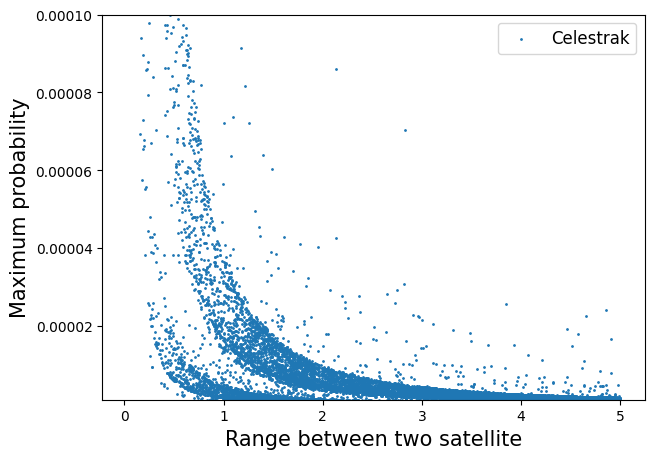

In [11]:
# data_trueprob = pd.read_csv('C:/Users/kuils/Desktop/스페이스맵/sort-minRange_24d13h.csv')
# data_trueprob =  pd.read_csv('C:/Users/kuils/Desktop/프로그래밍/TLE/MYTLE/spacemap_prj/celesresult/sort-minRange_24d13h.csv')#ground _true
data_trueprob = pd.read_csv('C:/Users/VDRC/Desktop/파이썬폴더/spacemap_prj/Main\Alfano Pcmax\Conjunction assesement result\Celestrak_CA_result\Celestrak_CA_09m24d13h.csv')
plt.figure(figsize=(7,5))
plt.scatter(data_trueprob['TCA_RANGE'][0::2], data_trueprob['MAX_PROB'][0::2],s=1,label="Celestrak")
#plt.scatter(data_trueprob['TCA_RANGE'], data_trueprob['prob'],s=1)
plt.ylim(1e-06,1e-04)
plt.xlabel(xlabel="Range between two satellite",fontsize=15)
plt.ylabel(ylabel="Maximum probability",fontsize=15)
plt.legend(fontsize=12)

# SPACEMAP_scatter+boxplot (x축:range y축:확률)

In [14]:
data_Spacemap = pd.read_csv('C:/Users/VDRC/Desktop/파이썬폴더/spacemap_prj/Main\Alfano Pcmax/Conjunction assesement result/Spacemap_CA_Result(N.Berend)/Berend_CA_09m24d13h.csv')
data_Spacemap.columns

Index(['CATEGORY', 'INDEX', 'NORAD_CAT_ID_1', 'OBJECT_NAME_1', 'SHAPE_1',
       'NORAD_CAT_ID_2', 'OBJECT_NAME_2', 'SHAPE_2', 'TCA', 'TCA_RANGE',
       'TCA_RELATIVE_SPEED', 'MAX_PROB', 'ERROR(RATIO)', 'RANEGE_ERROR'],
      dtype='object')

이상치 개수: 3615
총 개수: 36497
이상치 비율 0.09904923692358276


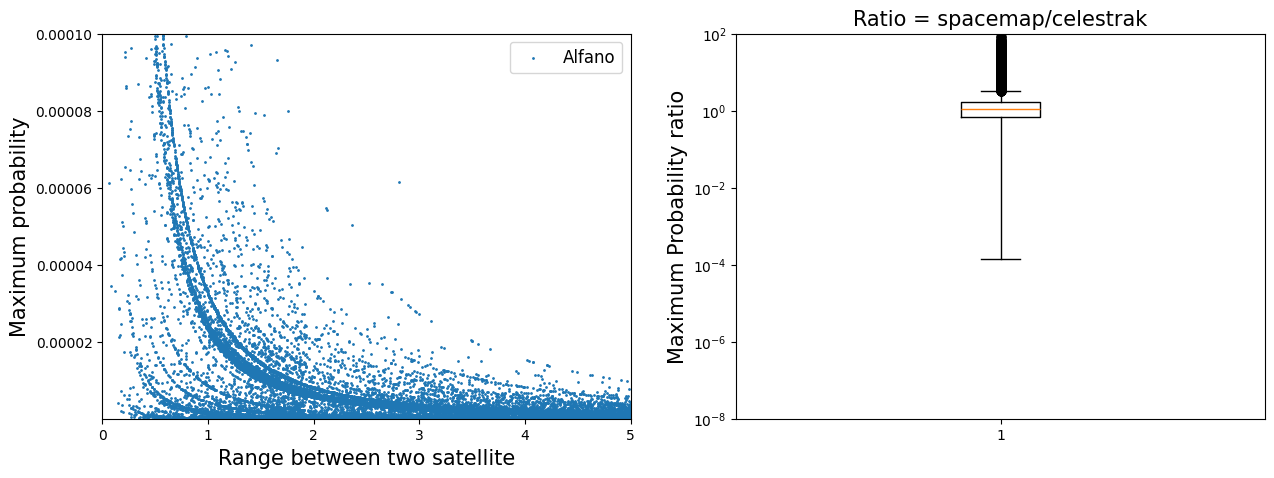

In [23]:
data_Spacemap = data_total = pd.read_csv('C:/Users/VDRC/Desktop/파이썬폴더/spacemap_prj/Main/Alfano Pcmax/Conjunction assesement result/Spacemap_CA_Result(Variable_HBR)/Spacemap_CA_09m24d13h.csv')

fig=plt.figure(figsize=(15,5))
ax1= fig.add_subplot(1,2,1)

ax1.scatter(data_Spacemap['TCA_RANGE'][1::2], data_Spacemap['PC_SPACEMAP'][1::2],s=1,label="Alfano")
ax1.set_ylim(1e-07,1e-04)
ax1.set_xlim(0,5)
ax1.set_xlabel(xlabel="Range between two satellite",fontsize=15)
ax1.set_ylabel(ylabel="Maximum probability",fontsize=15)
ax1.legend(fontsize=12)


ax2= fig.add_subplot(1,2,2)
ax2.boxplot(data_Spacemap['ERROR(RATIO)'][1::2])
# ax2.set_ylim(-2,2)
ax2.set_title('Ratio = spacemap/celestrak',fontsize=15)
ax2.set_ylabel('Maximum Probability ratio',fontsize=15)

ax2.set_yscale('log')
ax2.set_ylim(1e-08,1e02)



Q1 = np.percentile(data_Spacemap['ERROR(RATIO)'][1::2], 25)
Q3 = np.percentile(data_Spacemap['ERROR(RATIO)'][1::2], 75)
IQR = Q3 - Q1

# 이상치 경계 설정
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = data_Spacemap['ERROR(RATIO)'][1::2][(data_Spacemap['ERROR(RATIO)'][1::2] < lower_bound) | (data_Spacemap['ERROR(RATIO)'][1::2] > upper_bound)]

# 이상치 개수 출력
outlier_count = len(outliers)
total_count = len(data_Spacemap['ERROR(RATIO)'][1::2]) 
print("이상치 개수:", outlier_count )
print("총 개수:", total_count )
print("이상치 비율", outlier_count/total_count)

# spacemap_scatter2개 (x축: index, y축: MaxProbabilityRatio )

In [ ]:
SHAPE = ['Cyl','Cyl + 1 Nozzle','Oct Cyl','Hex Cyl','Box + 1 Pan' ,'Box + 2 Pan' , \
         'Box + 2 Ant' , 'Box + 3 Pan' , 'Box + 4 Pan', 'Box + 2 Pan + 1 Dish' , \
         'Box + 2 Pan + 1 Ant', 'Hex Cyl + 2 Pan + 1 Dish', 'Box + 1 Pan + 1 Ant'\
          'Box', 'Sphere','Cone','Sphere + Cyl','Cyl + Cone' ,'Cyl + 2 Pan'\
        , 'Hex Cyl + 2 Pan', 'Hex Cyl + 3 Pan', 'Half Hex Cyl + 2 Pan' \
       , 'Cyl + 4 Pan', 'Hex Cyl + 1 Pan','Trap Cyl + 2 Pan','Box + 1 Sail',\
          'Box + 1 Ant', 'Box + 1 Rod', 'Cyl + 1 Ant'  ]
filtered_data = data_total[data_total['SHAPE_1'].isin(SHAPE)]


14622
총 pair 개수 : 7311.0
0.1~10 범위 밖 개수 : 369
0.1~10 범위 내 개수 : 6942
범위 밖 비율 : 5.05%
범위 내 비율 : 94.95%
05~3 범위 밖 개수 : 5351
05~3 범위 내 개수 : 1960
범위 밖 비율 : 73.19%
범위 내 비율 : 26.81%


Text(6942, 0.1000189745815486, '0.1000')

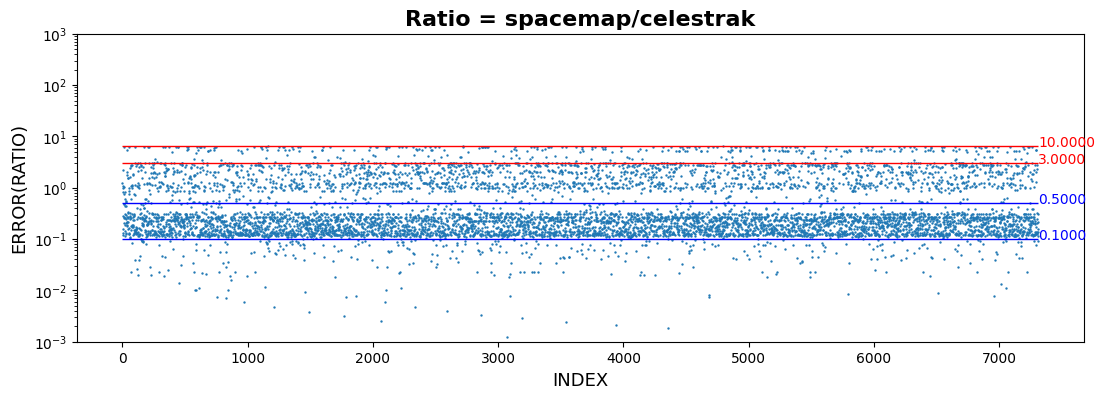

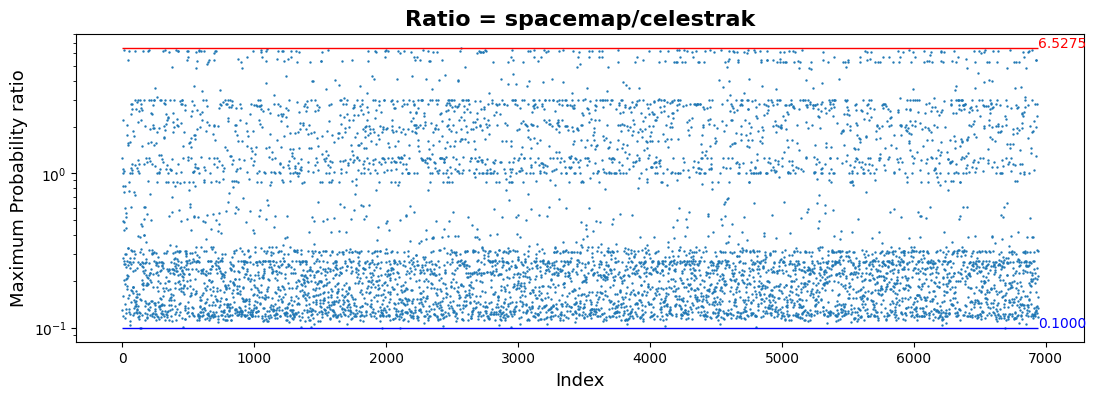

In [20]:
plt.figure(figsize=(13,4))
# data_total=  pd.read_csv('C:/Users/kuils/Desktop/프로그래밍/TLE/MYTLE/spacemap_prj/Berend/Berend_24d13h_total.csv')#ground

data_total = pd.read_csv('C:/Users/VDRC/Desktop/파이썬폴더/spacemap_prj/Main/Alfano Pcmax/Conjunction assesement result/Spacemap_CA_Result(Variable_HBR)/Spacemap_CA_09m24d13h_0D.csv')
data_total = data_total[(data_total['SHAPE_1'].isin(SHAPE)) & (data_total['SHAPE_2'].isin(SHAPE))]
print(len(data_total))
data_valid  = [value for value in data_total['ERROR(RATIO)'][1::2] if value >= 0.1 and value <=10 ]
data_valid2 = [value for value in data_total['ERROR(RATIO)'][1::2] if value >= 0.5 and value <=3 ]

plt.scatter(np.arange(len(data_total['ERROR(RATIO)'][1::2])),data_total['ERROR(RATIO)'][1::2] ,s=0.5)
plt.title('Ratio = spacemap/celestrak', fontsize=16, fontweight='bold')
plt.xlabel(xlabel="INDEX",fontsize=13)
plt.ylabel(ylabel="ERROR(RATIO)",fontsize=13)
plt.ylim(1e-03,1e03)
plt.yscale('log')

print("총 pair 개수 :", len(data_total)/2)
print("0.1~10 범위 밖 개수 :", len(data_total['ERROR(RATIO)'][1::2])- len(data_valid))
print('0.1~10 범위 내 개수 :',len(data_valid))
print(f"범위 밖 비율 : {round((len(data_total['ERROR(RATIO)'][1::2])- len(data_valid))*100/len(data_total['ERROR(RATIO)'][1::2]),2)}%")
print(f"범위 내 비율 : {round(len(data_valid)*100/len(data_total['ERROR(RATIO)'][1::2]),2)}%")

print("05~3 범위 밖 개수 :", len(data_total['ERROR(RATIO)'][1::2])- len(data_valid2))
print('05~3 범위 내 개수 :',len(data_valid2))
print(f"범위 밖 비율 : {round((len(data_total['ERROR(RATIO)'][1::2])- len(data_valid2))*100/len(data_total['ERROR(RATIO)'][1::2]),2)}%")
print(f"범위 내 비율 : {round(len(data_valid2)*100/len(data_total['ERROR(RATIO)'][1::2]),2)}%")

plt.hlines(max(data_valid), 0, len(data_total['ERROR(RATIO)'][1::2]), color='red', linestyle='solid', linewidth=1)
plt.hlines(np.min(np.array(data_valid)), 0, len(data_total['ERROR(RATIO)'][1::2]), color='b', linestyle='solid', linewidth=1)
plt.hlines(max(data_valid2), 0, len(data_total['ERROR(RATIO)'][1::2]), color='red', linestyle='solid', linewidth=1)
plt.hlines(np.min(np.array(data_valid2)), 0, len(data_total['ERROR(RATIO)'][1::2]), color='b', linestyle='solid', linewidth=1)
plt.text(len(data_total['ERROR(RATIO)'][1::2]), max(data_valid), f'{10:.4f}', fontsize=10, color='red')
plt.text(len(data_total['ERROR(RATIO)'][1::2]), np.min(np.array(data_valid)), f'{0.1:.4f}', fontsize=10, color='b')
plt.text(len(data_total['ERROR(RATIO)'][1::2]), max(data_valid2), f'{3:.4f}', fontsize=10, color='red')
plt.text(len(data_total['ERROR(RATIO)'][1::2]), np.min(np.array(data_valid2)), f'{0.5:.4f}', fontsize=10, color='b')
plt.figure(figsize=(13,4))
# 특정 범위내 scatter
plt.scatter(np.arange(len(data_valid)),data_valid,s=0.5)
plt.title('Ratio = spacemap/celestrak', fontsize=16, fontweight='bold')
plt.xlabel(xlabel="Index",fontsize=13)
plt.ylabel(ylabel="Maximum Probability ratio",fontsize=13)
plt.yscale('log')

plt.hlines(max(data_valid), 0, len(data_valid), color='red', linestyle='solid', linewidth=1)
plt.hlines(np.min(np.array(data_valid)), 0, len(data_valid), color='b', linestyle='solid', linewidth=1)
plt.text(len(data_valid), max(data_valid), f'{max(data_valid):.4f}', fontsize=10, color='red')
plt.text(len(data_valid), np.min(np.array(data_valid)), f'{np.min(data_valid):.4f}', fontsize=10, color='b')



# DICOSweb 사이즈 정보 불러오기

In [64]:
DISCOS_URL = 'https://discosweb.esoc.esa.int'
DISCOS_TOKEN = 'Ijk1YjRjMWYwLTc1ZDItNDc4NS04MzQ4LTgyZmM3MDk2M2IyYiI.lqet3mWHZooxHwUGaRqLBOTvYjI'
DISCOS_SATNO_MAX = 56685
DISCOS_PAGE_SIZE_MAX = 100

uriBase = "https://www.space-track.org"
requestLogin = "/ajaxauth/login"
requestCmdAction = "/basicspacedata/query"
requestFindObjects = f"/class/tle_latest/NORAD_CAT_ID/<{DISCOS_SATNO_MAX+1}/ORDINAL/1/format/json/orderby/NORAD_CAT_ID%20asc"

#id 1번 2번 설정.
if __name__ == '__main__':
    SATNO_LIST = list(Celestrak_data['NORAD_CAT_ID_1'])
    SATNO_LIST = [str(item) for item in SATNO_LIST]
    SATNO_LIST_CHUNK = [
            SATNO_LIST[i:i+100] 
            for i in range(0, len(SATNO_LIST), 100)
            ]
    dic_set = dict()
    for idx, chk in enumerate(SATNO_LIST_CHUNK):
            
                
        SATNO_CHUNK_STR = '(' + ','.join(chk) + ')'
        DISCOS_OBJECTS = get_discos_tle_objects(SATNO_CHUNK_STR) # ID에 해당하는 DISCOS 정보 불러오기 
        for obj in DISCOS_OBJECTS:
                
            dic_set[obj['attributes']['satno']] = obj['attributes']
        
        if (idx + 1) % 20 == 0:
            print(f'when {idx}th index, sleep')
            time.sleep(61)
    #파일 이름 설정
    with open(f'C:/Users/VDRC/Desktop/파이썬폴더/spacemap_prj/objects/size_11m07d05h_primary.txt', 'w') as file:
        json.dump(dic_set, file, indent='\t')

0.6379154451050771